# REGALS analysis of MsbA time-resolved data

 **The data were originally reported in:**

 Josts, I.; Gao, Y.; Monteiro, D. C. F.; Niebling, S.; Nitsche, J.; Veith, K.; Gräwert, T. W.; Blanchet, C. E.; Schroer, M. A.; Huse, N.; Pearson, A. R.; Svergun, D. I.; Tidow, H.  
 *Structural Kinetics of MsbA Investigated by Stopped-Flow Time-Resolved Small-Angle X-Ray Scattering.*
 Structure 2020, 28 (3), 348-354.e3. <https://doi.org/10.1016/j.str.2019.12.001>.

 **The scattering profiles were downloaded from:** SASBDB entry SASDGV5 on
 Aug 31, 2020.
 <https://www.sasbdb.org/data/SASDGV5/>

 **REGALS analysis script by:** Steve Meisburger, Aug 31, 2020

In [1]:
%matplotlib inline

import sys
import os
sys.path.append(os.path.abspath('../python/'))

import h5py
import numpy as np

from regals import *

import matplotlib.pyplot as plt

## Load data

In [2]:
MsbA_time_resolved = {}
with h5py.File('data/MsbA_time_resolved.mat', 'r') as f:
    for key in f:
        MsbA_time_resolved[key] = np.array(f[key])

#Store raw data
q = MsbA_time_resolved['q'][0]
I = MsbA_time_resolved['I'].T
sigma = MsbA_time_resolved['sigma'].T
ms = MsbA_time_resolved['ms'].T[0]

# remove the very low-q data (poor background subtraction?)
isincl = q > 0.015
q = q[isincl]
I = I[isincl,:]
sigma = sigma[isincl,:]

# optional: de-jitter using polynomial smoothing
yfit = np.polyval(np.polyfit(np.log10(ms),sum(I,0),5),np.log10(ms))
f = yfit/sum(I,0)
I = I*f
sigma = sigma*f

## Set up REGALS calculation

Each component has a concentration and profile regularizer.

In [3]:
x = ms.copy()
x = np.log10(x) # we're going to seek smoothness on a logarithmic scale

C1 = component(
    concentration_class('smooth', x, xmin = 1.3, xmax = 5.1, is_zero_at_xmin = False, is_zero_at_xmax = True, Nw = 31),
    profile_class('realspace',q, dmax = 70, Nw = 101))

C2 = component(
    concentration_class('smooth', x, xmin = 1.3, xmax = 5.1, is_zero_at_xmin = False, is_zero_at_xmax = False, Nw = 31),
    profile_class('realspace',q, dmax = 62, Nw = 101))

M = mixture([C1,C2])
M.lambda_concentration = np.array([1E-3,1E-3])
M.lambda_profile = np.array([1E11,1E11])

## Run REGALS

In [4]:
R = regals(I,sigma) # creat REGALS object

# set stopFun to return true when 400 iterations is exceeded
stop_fun = lambda num_iter, params: [num_iter >= 100, 'max_iter']

update_fun = lambda num_iter, mix, params,resid: \
    print('%2d, x2 = %f, delta_profile = %s'%(num_iter,params['x2'],np.array2string(params['delta_profile'],precision=3))) if num_iter%10 == 0 else None

# run for 50 iterations
[M1,params,resid,exit_cond] = R.run(M,stop_fun,update_fun)

10, x2 = 0.338732, delta_profile = [0.229 0.09 ]
20, x2 = 0.338118, delta_profile = [0.183 0.018]
30, x2 = 0.337513, delta_profile = [0.177 0.017]
40, x2 = 0.336973, delta_profile = [0.172 0.016]
50, x2 = 0.336488, delta_profile = [0.167 0.015]
60, x2 = 0.336049, delta_profile = [0.162 0.014]
70, x2 = 0.335651, delta_profile = [0.158 0.013]
80, x2 = 0.335288, delta_profile = [0.154 0.012]
90, x2 = 0.334955, delta_profile = [0.15  0.011]
100, x2 = 0.334649, delta_profile = [0.147 0.011]


## Extract results to plot

In [5]:
# P(r) functions
r1 = M1.components[0].profile.w
pr1 = np.concatenate([[0],M1.u_profile[0],[0]])

r2 = M1.components[1].profile.w
pr2 = np.concatenate([[0],M1.u_profile[1],[0]])

# Particle components (no regularization)
[I1,sigma1] = M1.extract_profile(I,sigma,0)
[I2,sigma2] = M1.extract_profile(I,sigma,1)

# Concentration components (no regularization)
p1 = M1.extract_concentration(I,sigma,0)[0]
p2 = M1.extract_concentration(I,sigma,1)[0]

# Regularized concentrations
x1 = M1.components[1].concentration.w
c1 = np.concatenate([M1.u_concentration[0],[0]])
x2 = M1.components[1].concentration.w
c2 = M1.u_concentration[1]

## Plot the end results

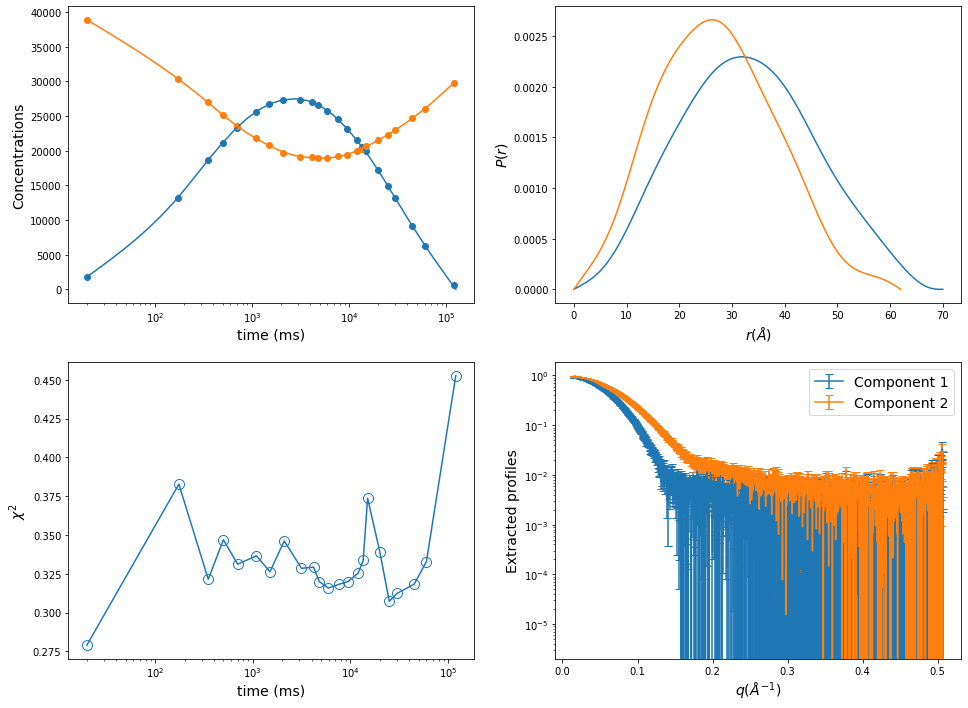

In [6]:
# plot the end results
plt.rcParams['figure.figsize'] = 16, 12
fig, axs = plt.subplots(2, 2)

#concentrations vs x
axs[0, 0].semilogx(10**x1, c1)
axs[0, 0].semilogx(10**x2, c2)
axs[0, 0].scatter(10**x, p1)
axs[0, 0].scatter(10**x, p2)
axs[0, 0].set_xlabel('time (ms)', fontsize=14)
axs[0, 0].set_ylabel('Concentrations', fontsize=14)

#chi2 vs x
axs[1, 0].semilogx(10**x, np.mean(resid ** 2, 0), fillstyle= 'none', marker = 'o', markersize=10)
axs[1, 0].set_xlabel('time (ms)', fontsize=14)
axs[1, 0].set_ylabel('$\chi^2$', fontsize=14)

#P(r) vs r
axs[0, 1].plot(r1, pr1)
axs[0, 1].plot(r2, pr2)
axs[0, 1].set_xlabel('$r (Å)$', fontsize=14)
axs[0, 1].set_ylabel('$P(r)$', fontsize=14)

#extracted profiles
axs[1, 1].errorbar(q, I1, sigma1, capsize=4, label='Component 1')
axs[1, 1].errorbar(q, I2, sigma2, capsize=4, label='Component 2')
axs[1, 1].set_xscale('linear')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[1, 1].set_ylabel('Extracted profiles', fontsize=14)
plt.legend(fontsize=14)

plt.show()